In [1]:
import numpy as np
import matplotlib.pyplot as plt
from general_IO import read_column

## Utility functions

In [2]:
def ByteToMegaByte(_bytes):
    return _bytes / (1024*1024)

def NanoToMilli(_ns):
    return _ns / 1000000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: >

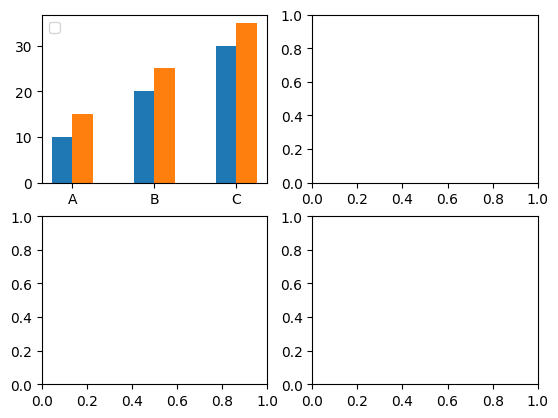

In [28]:
def plot_multibar(_ax, x_coordinates, x_labels, data_arrays, _plotTitle="", _plotXLabel="", _plotYLabel="", _dataLabels=[]):
    """
    Plot multiple bar charts.

    Parameters:
    - _ax (matplotlib.axes.Axes): The axes object to plot the data on.
    - x_coordinates (list): The x-coordinates of the bars.
    - x_labels (list): The labels for the x-axis.
    - data_arrays (list): The data arrays to be plotted.
    - _plotTitle (str): The title of the plot (optional).
    - _plotXLabel (str): The label for the x-axis (optional).
    - _plotYLabel (str): The label for the y-axis (optional).
    - _dataLabels (list): The labels for each data array (optional).

    Returns:
    - fig (matplotlib.figure.Figure): The figure object.
    - ax (matplotlib.axes.Axes): The axes object.
    """
    # Set the width of the bars
    bar_width = max(x_coordinates) / (len(x_coordinates) * 2)

    # Adjust the x-axis positions for the bars
    x_positions = np.array(x_coordinates) - bar_width/2
    x_positions_labels = np.zeros(len(x_coordinates))

    # Calculate the number of data arrays
    num_data_arrays = len(data_arrays)

    # Calculate the bar width for each data array
    bar_width_per_array = bar_width / num_data_arrays

    # Plotting
    for i, data_array in enumerate(data_arrays):
        # Adjust the x-axis positions for each data array
        x_positions_i = x_positions + i * bar_width_per_array
        x_positions_labels += x_positions_i/num_data_arrays

        # Plot the data array
        if (_dataLabels == []):
            _ax.bar(x_positions_i, data_array, width=bar_width_per_array)
        else:
            _ax.bar(x_positions_i, data_array, width=bar_width_per_array, label=_dataLabels[i])

    # Customize the plot
    _ax.set_xlabel(_plotXLabel)
    _ax.set_ylabel(_plotYLabel)
    _ax.set_title(_plotTitle)
    _ax.legend()

    # Set the x tick labels
    _ax.set_xticks(x_positions_labels)
    _ax.set_xticklabels(x_labels)

    return _ax

# Sample data
fig, ax = plt.subplots(2,2)
x_coordinates = [1, 2, 3]
data1 = [10, 20, 30]
data2 = [15, 25, 35]
x_labels = ['A', 'B', 'C']

# Call the function
plot_multibar(ax[0,0], x_coordinates, x_labels, [data1, data2])


## Config parameters

In [4]:
nbRepeats=100 #Number of time we run the writing process
nbRefs=[10, 100, 1000, 10000] #Number of objects for which we will override the translation, rotation, and scale.
nbBatch=[1, 2, 5, 10] #number of files in which the objects are going to be dispatched.
usdExtension = ["usda", "usdc"] #whether we use usda or usdc
totalBytesWritten=[3*3*4*_nbRefs for _nbRefs in nbRefs] #Size of the file in bytes

## Load all data 

In [5]:
dataFolder="./RuntimeResults"

allData = {}
allHeaders = {}

for _nbRefs in nbRefs:
    for _nbBatch in nbBatch:
        for _usdExtension in usdExtension:

            _totalBytesWritten=3*3*4*_nbRefs
            key=(_totalBytesWritten, _nbRefs, _nbBatch, _usdExtension)
            filename = "{}_bytes__for_{}_objects_in_{}_{}_files.csv".format(_totalBytesWritten, _nbRefs, _nbBatch, _usdExtension)

            #Read the data
            timingsSTR = read_column(dataFolder, filename, [1,2,3,4], ",")
            timingsHeaders = timingsNames=["UsdCreate", "Define World", "Add {} Refs\nto {} File(s)".format(_nbRefs, _nbBatch), "Save {} File".format(_nbBatch)]
            timingsSTRSplit = [timing.split() for timing in timingsSTR[1:]]
            timingsNs = np.array(timingsSTRSplit).astype(np.int64)

            #save the data
            allData[key] = timingsNs
            allHeaders[key] = timingsHeaders


## Show timings in milliseconds for each of the "4 parts" of the writing procedure
See the function WriteUSDStage in `./WriteUSDStageProfiling.py` for the "4 parts"

The following is a demonstration of what we will be ploting:

Average times in ms:[ 2.331434  2.449762  8.017154 10.483139]
Standard Deviation of the times in ms:[1.02052549 1.14549029 1.94084563 2.06716452]


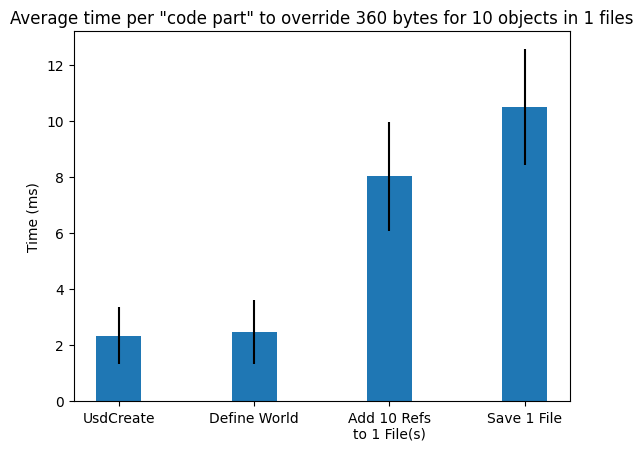

In [6]:
#Local variables to facilitate the access to the data
_nbRefs = nbRefs[0]
_nbBatch = nbBatch[0]
_usdExtension = usdExtension[0]
_totalBytesWritten = 3*3*4*_nbRefs
_key=(_totalBytesWritten, _nbRefs, _nbBatch, _usdExtension)

localTimingsNS = allData[_key]

#Use NanoToMilli to convert the timings from nanoseconds to milliseconds
locaTimingsMs= NanoToMilli(localTimingsNS)

averageTimingsMs = np.mean(locaTimingsMs, axis = 0)
print("Average times in ms:{}".format(averageTimingsMs))

stdTimingsMs = np.std(locaTimingsMs, axis = 0)
print("Standard Deviation of the times in ms:{}".format(stdTimingsMs))

title = "Average time per \"code part\" to override {} bytes for {} objects in {} files".format(_totalBytesWritten, _nbRefs, _nbBatch)

plt.bar(np.arange(4)*30, averageTimingsMs, 10, tick_label=allHeaders[_key], yerr = stdTimingsMs)
plt.ylabel("Time (ms)")
plt.title(title)
plt.show()

### Compare USDA and USDC files

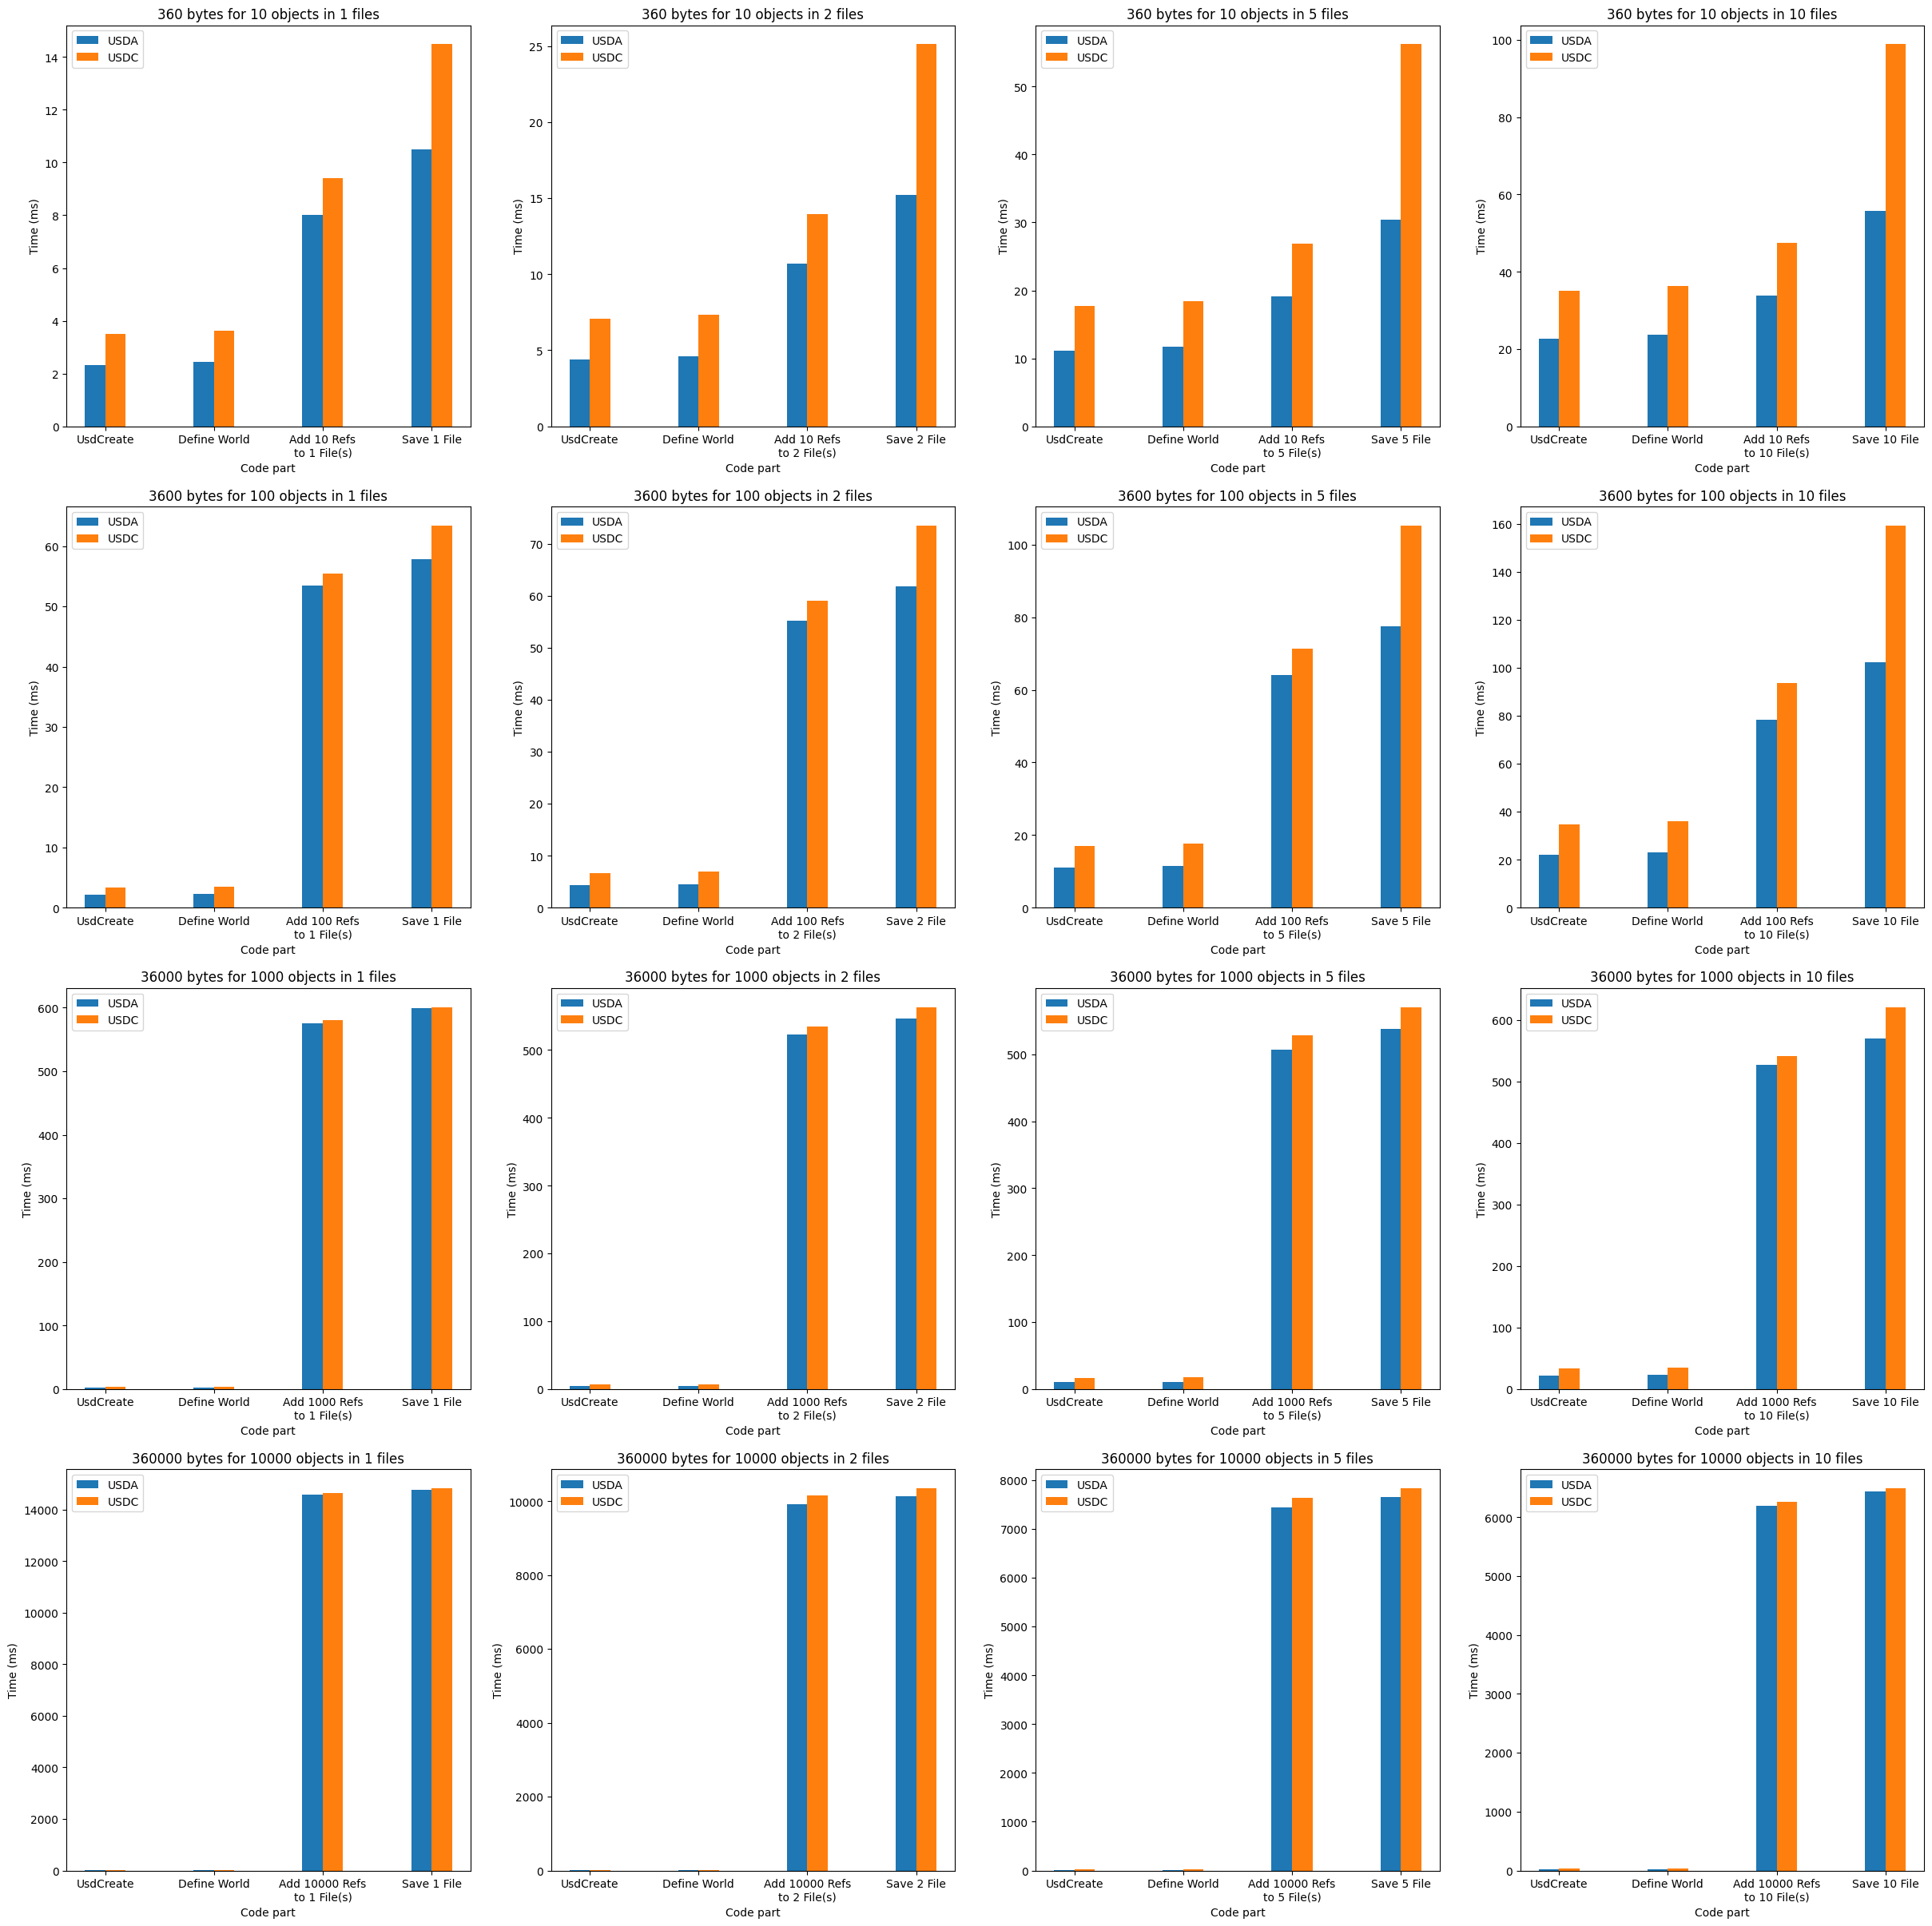

In [34]:
import matplotlib.pyplot as plt

# Set the nbRefs values
nbRefs_values = nbRefs

# Set the usdExtension values
usdExtension_values = usdExtension

x_labels = []

averageTimingsMs = {}
stdTimingsMs = {}
# Loop through the nbRefs values
for _nbRefs in nbRefs:
    # Loop through the usdExtension values
    for _usdExtension in usdExtension:
        # Loop through the nbBatch values
        for _nbBatch in nbBatch:
            # Get the key for the current nbRefs value, usdExtension value, and nbBatch value
            key = (3*3*4*_nbRefs, _nbRefs, _nbBatch, _usdExtension)
            
            # Get the average timings in milliseconds for the current key
            timings_ms = NanoToMilli(allData[key])
            averageTimingsMs[key] = np.mean(timings_ms, axis = 0)
            stdTimingsMs[key] = np.std(timings_ms, axis = 0)

            # Set the x-axis labels
            x_labels += [allHeaders[key]]

# Create a figure and a grid of subplots
fig, axs = plt.subplots(len(nbRefs), len(nbBatch), figsize=(30, 30))
for i in range(len(nbRefs)):
    for j in range(len(nbBatch)):
        # Get the key for the current nbRefs value, usdExtension value, and nbBatch value
        keyUSDA = (3*3*4*nbRefs[i], nbRefs[i], nbBatch[j], usdExtension[0])
        keyUSDC = (3*3*4*nbRefs[i], nbRefs[i], nbBatch[j], usdExtension[1])
        # Set the title for the bar plot
        title = "{} bytes for {} objects in {} files".format(3*3*4*nbRefs[i], nbRefs[i], nbBatch[j])
        plot_multibar(axs[i,j], np.arange(4)*30, allHeaders[keyUSDA], [averageTimingsMs[keyUSDA], averageTimingsMs[keyUSDC]], _plotTitle=title, _plotXLabel="Code part", _plotYLabel="Time (ms)", _dataLabels=["USDA", "USDC"])